# Sentiment Analysis of Yelp Reviews (Pre Processing / Modeling)

---

## Contents

* [Introduction](#Introduction)
* [Categorization and Dummy Variables](#Dummy)
* [CountVectorizer](#CountVectorizer)
* [TFIDF](#TFIDF)
* [Bigrams](#bigrams)
* [Creating a Training Dataset](#Train)
* [Conclusion](#Conclusion)

---

## Introduction

In the last notebook, we explored the relationships in our data and found things like polarity which help label our training data. In this notebook, we're going to prepare our data so that we can use it as an effective train/test split for building a model in the final notebook

We need to do a few things:

* Categorize and label the data
* Convert the cleaned reviews into vector data
* Create a pipeline using a text vectorization method
* Test the newly categorized / vectorized data on a simple logistic regression

---

### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

from pycm import *

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
yelp_data = pd.read_csv('./data/yelp_data_final_2.csv')

In [3]:
yelp_data.head()

,alias,name,rating,price,city,zip_code,address,review,word_count,review_cleaned,review_lemmatized,review_stemmed,word_count_stemmed,positive_word_count,proportion_positive,polarity,subjectivity
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,morris park bake shop has become my go to spot...,49,morris park bake shop become go spot atmospher...,morris park bake shop become go spot atmospher...,morri park bake shop becom go spot atmospher p...,28,6,0.2143,0.338889,0.552778
1,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i thought the cookies and biscotti were prett...,122,thought cookies biscotti pretty good definitel...,thought cooky biscotti pretty good definitely ...,thought cooki biscotti pretti good definit tas...,60,9,0.1500,0.314583,0.438194
2,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,guys.... so im a big time biscotti connoisseu...,169,guys im big time biscotti connoisseur always h...,guy im big time biscotti connoisseur always hu...,guy im big time biscotti connoisseur alway hun...,88,13,0.1477,0.238068,0.587311
3,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i had a craving for a special type of cake wi...,59,craving special type cake ice cream layer regu...,craving special type cake ice cream layer regu...,crave special type cake ice cream layer regula...,29,7,0.2414,0.314643,0.536044
4,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,the chocolate cups are amazing! have been eat...,16,chocolate cups amazing eating years always tas...,chocolate cup amazing eating year always taste...,chocol cup amaz eat year alway tast fantast,8,2,0.2500,0.500000,0.900000


In [4]:
yelp_data.shape

(14742, 17)

## Categorization and Dummy Variables <a id='Dummy'></a>

Before we get started with our model we need to categorize our data into groups that our model can sort by. In this case, because we're doing a sentiment analysis, we're going to sort our data into 'positive' and 'negative' sentiment reviews based on each review's TextBlob Polarity.

---

In [5]:
# Keep polarity values that are not 0
yelp_data = yelp_data[yelp_data['polarity'] != 0]
yelp_data.shape

(14630, 17)

In [6]:
# Reset index
yelp_data.reset_index(inplace=True)

In [7]:
yelp_data['sentiment'] = yelp_data['polarity'].apply(lambda p: 'positive' if p > 0 else 'negative')
yelp_data.head()

,index,alias,name,rating,price,city,zip_code,address,review,word_count,review_cleaned,review_lemmatized,review_stemmed,word_count_stemmed,positive_word_count,proportion_positive,polarity,subjectivity,sentiment
0,0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,morris park bake shop has become my go to spot...,49,morris park bake shop become go spot atmospher...,morris park bake shop become go spot atmospher...,morri park bake shop becom go spot atmospher p...,28,6,0.2143,0.338889,0.552778,positive
1,1,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i thought the cookies and biscotti were prett...,122,thought cookies biscotti pretty good definitel...,thought cooky biscotti pretty good definitely ...,thought cooki biscotti pretti good definit tas...,60,9,0.1500,0.314583,0.438194,positive
2,2,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,guys.... so im a big time biscotti connoisseu...,169,guys im big time biscotti connoisseur always h...,guy im big time biscotti connoisseur always hu...,guy im big time biscotti connoisseur alway hun...,88,13,0.1477,0.238068,0.587311,positive
3,3,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i had a craving for a special type of cake wi...,59,craving special type cake ice cream layer regu...,craving special type cake ice cream layer regu...,crave special type cake ice cream layer regula...,29,7,0.2414,0.314643,0.536044,positive
4,4,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,the chocolate cups are amazing! have been eat...,16,chocolate cups amazing eating years always tas...,chocolate cup amazing eating year always taste...,chocol cup amaz eat year alway tast fantast,8,2,0.2500,0.500000,0.900000,positive


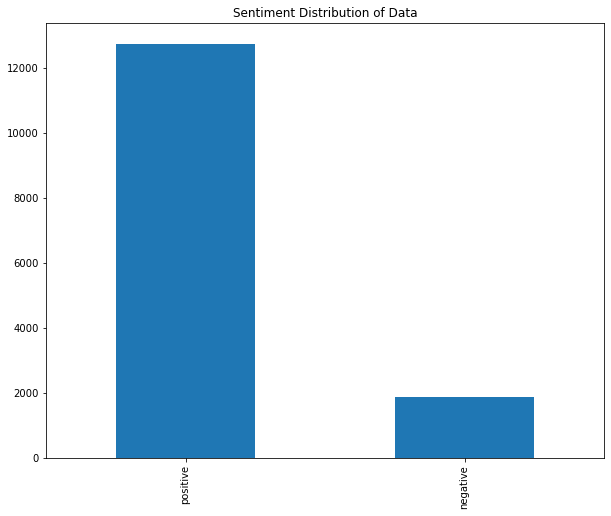

In [8]:
plt.figure(figsize=(10,8))
yelp_data['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution of Data')
plt.show()

In [9]:
yelp_data['sentiment'].value_counts(normalize=True)

positive    0.87177
negative    0.12823
Name: sentiment, dtype: float64

---

As you can see, most of our reviews are positive. Let's see if we can sort it out even more for better results.

---

In [10]:
def determine_sentiment(polarity):
    if polarity >= 0.4:
        return 'positive'
    elif polarity > 0.2 and polarity < 0.4:
        return 'slightly positive'
    elif polarity > 0 and polarity <= 0.2:
        return 'slightly negative'
    else: # polarity < 0
        return 'negative'
    
yelp_data['sentiment'] = yelp_data['polarity'].apply(lambda p: determine_sentiment(p))
yelp_data.head()

,index,alias,name,rating,price,city,zip_code,address,review,word_count,review_cleaned,review_lemmatized,review_stemmed,word_count_stemmed,positive_word_count,proportion_positive,polarity,subjectivity,sentiment
0,0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,morris park bake shop has become my go to spot...,49,morris park bake shop become go spot atmospher...,morris park bake shop become go spot atmospher...,morri park bake shop becom go spot atmospher p...,28,6,0.2143,0.338889,0.552778,slightly positive
1,1,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i thought the cookies and biscotti were prett...,122,thought cookies biscotti pretty good definitel...,thought cooky biscotti pretty good definitely ...,thought cooki biscotti pretti good definit tas...,60,9,0.1500,0.314583,0.438194,slightly positive
2,2,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,guys.... so im a big time biscotti connoisseu...,169,guys im big time biscotti connoisseur always h...,guy im big time biscotti connoisseur always hu...,guy im big time biscotti connoisseur alway hun...,88,13,0.1477,0.238068,0.587311,slightly positive
3,3,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,i had a craving for a special type of cake wi...,59,craving special type cake ice cream layer regu...,craving special type cake ice cream layer regu...,crave special type cake ice cream layer regula...,29,7,0.2414,0.314643,0.536044,slightly positive
4,4,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,the chocolate cups are amazing! have been eat...,16,chocolate cups amazing eating years always tas...,chocolate cup amazing eating year always taste...,chocol cup amaz eat year alway tast fantast,8,2,0.2500,0.500000,0.900000,positive


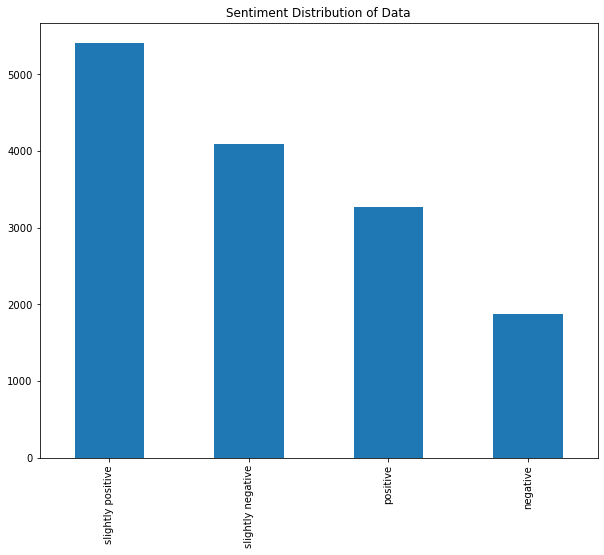

In [11]:
plt.figure(figsize=(10,8))
yelp_data['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution of Data')
plt.show()

In [12]:
yelp_data['sentiment'].value_counts(normalize=True)

slightly positive    0.369241
slightly negative    0.279152
positive             0.223377
negative             0.128230
Name: sentiment, dtype: float64

---

This is still a little biased towards positive reviews. Let's take a look at the proportion of positive words and how they change based on their sentiment category.

---

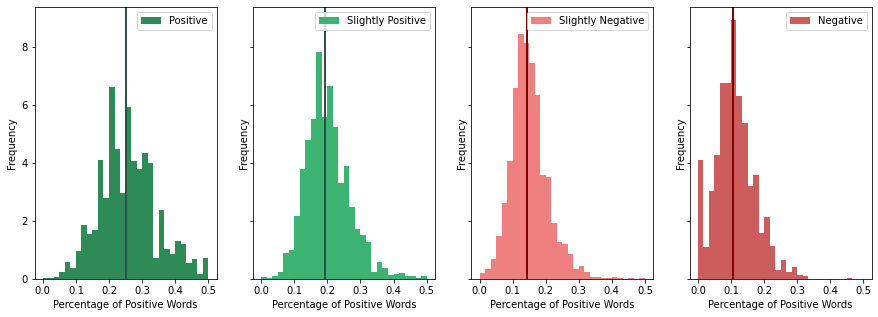

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(15,5), sharex=True, sharey=True)

# Positive
axs[0].hist(yelp_data[yelp_data['sentiment'] == 'positive']['proportion_positive'], bins=30, density=True, range=(0,0.5), color='seagreen', label='Positive')
axs[0].axvline(np.median(yelp_data[yelp_data['sentiment'] == 'positive']['proportion_positive']), color='darkslategray', linewidth=2)
axs[0].legend(loc='upper right')

# Slightly Positive
axs[1].hist(yelp_data[yelp_data['sentiment'] == 'slightly positive']['proportion_positive'], bins=30, density=True, range=(0,0.5), color='mediumseagreen', label='Slightly Positive')
axs[1].axvline(np.median(yelp_data[yelp_data['sentiment'] == 'slightly positive']['proportion_positive']), color='darkslategray', linewidth=2)
axs[1].legend(loc='upper right')

# Slightly negative
axs[2].hist(yelp_data[yelp_data['sentiment'] == 'slightly negative']['proportion_positive'], bins=30, density=True, range=(0,0.5), color='lightcoral', label='Slightly Negative')
axs[2].axvline(np.median(yelp_data[yelp_data['sentiment'] == 'slightly negative']['proportion_positive']), color='maroon', linewidth=2)
axs[2].legend(loc='upper right')

# Negative
axs[3].hist(yelp_data[yelp_data['sentiment'] == 'negative']['proportion_positive'], bins=30, density=True, range=(0,0.5), color='indianred', label='Negative')
axs[3].axvline(np.median(yelp_data[yelp_data['sentiment'] == 'negative']['proportion_positive']), color='maroon', linewidth=2)
axs[3].legend(loc='upper right')

for ax in axs.flat:
    ax.set(xlabel='Percentage of Positive Words', ylabel='Frequency')
plt.show()

In [14]:
pos_med = np.median(yelp_data[yelp_data['sentiment'] == 'positive']['proportion_positive'])
slightly_pos_med = np.median(yelp_data[yelp_data['sentiment'] == 'slightly positive']['proportion_positive'])
slightly_neg_med = np.median(yelp_data[yelp_data['sentiment'] == 'slightly negative']['proportion_positive'])
neg_med = np.median(yelp_data[yelp_data['sentiment'] == 'negative']['proportion_positive'])


print(f'         Median of positive sentiment:     {pos_med}\n'
      f'Median of slightly positive sentiment:     {slightly_pos_med}\n'
      f'Median of slightly negative sentiment:     {slightly_neg_med}\n'
      f'         Median of negative sentiment:     {neg_med}')

         Median of positive sentiment:     0.25
Median of slightly positive sentiment:     0.1923
Median of slightly negative sentiment:     0.1441
         Median of negative sentiment:     0.1064


---

Now that we have our data categorized, we're going to need to convert our tokenized reviews into word vectors using two different approaches: [CountVectorizer](#CountVectorizer) and [TFIDF](#TFIDF).

---

## CountVectorizer <a id='CountVectorizer'></a>

The CountVectorizer uses the bag of words approach to convert text to word counts and, more importantly, a vector. The vector for each word, paragraph, or sentence can then be compared to other vectors and we can see which ones are the most similar.

I'll start with the first two reviews from one location to demonstrate how CountVectorizer works:

---

In [15]:
example_text = yelp_data['review_cleaned'][:2]
vectorizer = CountVectorizer()
vector = vectorizer.fit_transform(example_text)

# Summary
print('List of unique words: ', vectorizer.vocabulary_)
print('\n')
print('Shape of the sparse matrix ', vector.shape)
print('\n')
print(vector.toarray())

List of unique words:  {'morris': 38, 'park': 41, 'bake': 7, 'shop': 51, 'become': 8, 'go': 23, 'spot': 53, 'atmosphere': 5, 'place': 42, 'great': 25, 'inviting': 29, 'love': 32, 'every': 18, 'thing': 58, 'ordered': 40, 'staff': 54, 'really': 48, 'pleasant': 44, 'definitely': 16, 'help': 27, 'anything': 4, 'come': 14, 'back': 6, 'thought': 59, 'cookies': 15, 'biscotti': 10, 'pretty': 46, 'good': 24, 'tasty': 55, 'nothing': 39, 'blew': 11, 'water': 63, 'rock': 49, 'hard': 26, 'almond': 1, 'probably': 47, 'best': 9, 'however': 28, 'didnt': 17, 'feel': 19, 'wonderfully': 66, 'safe': 50, 'walked': 62, 'man': 33, 'toward': 60, 'mask': 34, 'another': 3, 'female': 20, 'member': 36, 'chin': 13, 'members': 37, 'masks': 35, 'isnt': 30, 'walk': 61, 'additionally': 0, 'theyre': 57, 'cash': 12, 'whatever': 65, 'know': 31, 'plenty': 45, 'places': 43, 'wouldnt': 67, 'way': 64, 'get': 22, 'something': 52, 'already': 2, 'thats': 56, 'fine': 21}


Shape of the sparse matrix  (2, 68)


[[0 0 0 0 1 1 1 2 

---

Here we've got 68 unique words in two reviews. If there's a 1 in the sparse matrix, it that means the word is present and a 0 means the word did not make an appearance. 2's and other values simply mean that the unique word appears multiple times

---

## TFIDF <a id='TFIDF'></a>

TFIDF stands for Term Frequency Inverse Document Frequency which means that in addition to measuring the word frequency in each review we can also measure how frequently a word appears among all lines of text. This is really important when it comes to picking out very unique words.

---

In [16]:
tf_vectorizer = TfidfVectorizer()
tf_vector = tf_vectorizer.fit_transform(example_text)

# Summary
print('List of unique words: ', tf_vectorizer.vocabulary_)
print('\n')
print('Shape of the sparse matrix ',tf_vector.shape)
print('\n')
print(tf_vector.toarray())

List of unique words:  {'morris': 38, 'park': 41, 'bake': 7, 'shop': 51, 'become': 8, 'go': 23, 'spot': 53, 'atmosphere': 5, 'place': 42, 'great': 25, 'inviting': 29, 'love': 32, 'every': 18, 'thing': 58, 'ordered': 40, 'staff': 54, 'really': 48, 'pleasant': 44, 'definitely': 16, 'help': 27, 'anything': 4, 'come': 14, 'back': 6, 'thought': 59, 'cookies': 15, 'biscotti': 10, 'pretty': 46, 'good': 24, 'tasty': 55, 'nothing': 39, 'blew': 11, 'water': 63, 'rock': 49, 'hard': 26, 'almond': 1, 'probably': 47, 'best': 9, 'however': 28, 'didnt': 17, 'feel': 19, 'wonderfully': 66, 'safe': 50, 'walked': 62, 'man': 33, 'toward': 60, 'mask': 34, 'another': 3, 'female': 20, 'member': 36, 'chin': 13, 'members': 37, 'masks': 35, 'isnt': 30, 'walk': 61, 'additionally': 0, 'theyre': 57, 'cash': 12, 'whatever': 65, 'know': 31, 'plenty': 45, 'places': 43, 'wouldnt': 67, 'way': 64, 'get': 22, 'something': 52, 'already': 2, 'thats': 56, 'fine': 21}


Shape of the sparse matrix  (2, 68)


[[0.         0.   

---

Let's see how we can make these metrics even better for our model.

---

## Bigrams <a id='bigrams'></a>

Bigrams can be very important for this model because of how people reivews. Phrases like 'No good' or 'not bad' are very common but if you tokenize them into individual words, it completely changes the meaning. Bigrams turn these tokens into token pairs and create more unique pairs with more meaning.

---

In [17]:
vectorizer = CountVectorizer(ngram_range=(1,2))
vector = vectorizer.fit_transform(example_text)

# Summary
print('List of unique words: ', vectorizer.vocabulary_)
print('\n')
print('Shape of the sparse matrix ', vector.shape)
print('\n')
print(vector.toarray())

List of unique words:  {'morris': 85, 'park': 91, 'bake': 15, 'shop': 114, 'become': 17, 'go': 52, 'spot': 119, 'atmosphere': 10, 'place': 93, 'great': 57, 'inviting': 66, 'love': 72, 'every': 42, 'thing': 131, 'ordered': 89, 'staff': 121, 'really': 105, 'pleasant': 97, 'definitely': 36, 'help': 62, 'anything': 8, 'come': 32, 'back': 12, 'morris park': 86, 'park bake': 92, 'bake shop': 16, 'shop become': 115, 'become go': 18, 'go spot': 53, 'spot atmosphere': 120, 'atmosphere place': 11, 'place great': 94, 'great inviting': 58, 'inviting love': 67, 'love every': 73, 'every thing': 43, 'thing ordered': 132, 'ordered staff': 90, 'staff really': 124, 'really pleasant': 108, 'pleasant definitely': 98, 'definitely help': 38, 'help anything': 63, 'anything definitely': 9, 'definitely come': 37, 'come back': 33, 'back morris': 13, 'thought': 133, 'cookies': 34, 'biscotti': 21, 'pretty': 101, 'good': 55, 'tasty': 125, 'nothing': 87, 'blew': 24, 'water': 141, 'rock': 110, 'hard': 60, 'almond': 

### min_df and max_df parameters

`min_df` and `max_df` basically set limits on how much of the data we want to display in these arrays. `min_df` specifies a frequency threshold and ignores a word below this frequency. In contrast, `max_df` does the opposite — it ignores terms that have a frequency strictly higher than the specified threshold.

Specifying `min_df` and `max_df` saves time and memory for the code and filters out the words that only appear a couple of times (which are usually spelling errors anyway)

---

In [18]:
example_text = yelp_data['review_cleaned'][:3]
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2)
vector = vectorizer.fit_transform(example_text)

# Summary
print('List of unique words: ', vectorizer.vocabulary_)
print('\n')
print('Shape of the sparse matrix ', vector.shape)
print('\n')
print(vector.toarray())

List of unique words:  {'morris': 10, 'park': 12, 'bake': 1, 'shop': 15, 'go': 7, 'great': 8, 'staff': 16, 'really': 14, 'definitely': 6, 'back': 0, 'morris park': 11, 'park bake': 13, 'bake shop': 2, 'cookies': 5, 'biscotti': 4, 'hard': 9, 'best': 3}


Shape of the sparse matrix  (3, 17)


[[1 2 2 0 0 0 2 1 1 0 2 2 2 2 1 2 1]
 [1 0 0 1 2 1 1 1 1 1 0 0 0 0 3 1 2]
 [0 1 1 2 6 1 0 0 0 3 1 1 1 1 0 1 0]]


---

In the example text, out of 3 reviews, these are the only words that appeared in two or more reviews.

---

## Creating a Training Dataset <a id='Train'></a>

In [19]:
text = yelp_data['review_stemmed']
tf_vectorizer = TfidfVectorizer()
tf_vector = tf_vectorizer.fit_transform(text)

In [20]:
vocab = tf_vectorizer.vocabulary_
vocab_df = pd.DataFrame(tf_vector.toarray(), columns=vocab)

col_name1 ='resturant_name'
col_name2 = 'yelp_review'
col_name3 = 'polarity'
col_name4 = 'review_sentiment'
col_name5 = 'proportion_positive'

col1 = yelp_data['name']
col2 = yelp_data['review']
col3 = yelp_data['polarity']
col4 = yelp_data['sentiment']
col5 = yelp_data['proportion_positive']

vocab_df.insert(0, col_name1, col1)
vocab_df.insert(1, col_name2, col2)
vocab_df.insert(2, col_name3, col3)
vocab_df.insert(3, col_name4, col4)
vocab_df.insert(4, col_name5, col5)

In [21]:
vocab_df.head()

,resturant_name,yelp_review,polarity,review_sentiment,proportion_positive,morri,park,bake,shop,becom,...,snort,puertorico,gargoyl,brokelyn,lookpro,osstyrofoam,cupswomen,tnt,behnam,bartenderswhat
0,Morris Park Bake Shop,morris park bake shop has become my go to spot...,0.338889,slightly positive,0.2143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Morris Park Bake Shop,i thought the cookies and biscotti were prett...,0.314583,slightly positive,0.1500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Morris Park Bake Shop,guys.... so im a big time biscotti connoisseu...,0.238068,slightly positive,0.1477,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Morris Park Bake Shop,i had a craving for a special type of cake wi...,0.314643,slightly positive,0.2414,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Morris Park Bake Shop,the chocolate cups are amazing! have been eat...,0.500000,positive,0.2500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X = vocab_df.iloc[:,4:] # features
y = vocab_df['review_sentiment'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f'X_train size: {X_train.shape}\n'
      f' X_test size: {X_test.shape}\n'
      f'y_train size: {y_train.shape}\n'
      f' y_test size: {y_test.shape}')

X_train size: (10241, 18024)
 X_test size: (4389, 18024)
y_train size: (10241,)
 y_test size: (4389,)


In [23]:
log_reg = LogisticRegression()
model = Pipeline([('classifier', log_reg)])

model.fit(X_train, y_train)
predictions = model.predict(X_test)

Accuracy Score:  0.6967418546365914


Overall Statistics : 

ACC Macro                                                         0.84837
F1 Macro                                                          0.69467
FPR Macro                                                         0.11093
Kappa                                                             0.56888
Overall ACC                                                       0.69674
PPV Macro                                                         0.72536
SOA1(Landis & Koch)                                               Moderate
TPR Macro                                                         0.67583
Zero-one Loss                                                     1331

Class Statistics :

Classes                                                           negative              positive              slightly negative     slightly positive     
ACC(Accuracy)                                                     0.93096               0.89291    

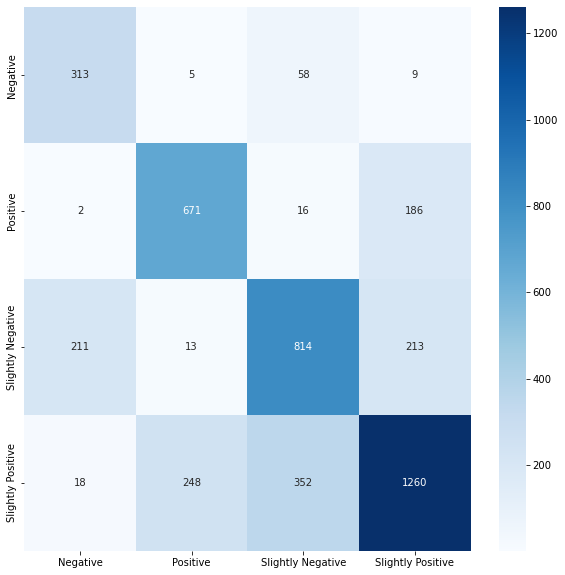

In [24]:
cm_matrix = confusion_matrix(predictions, y_test)
cm_df =  pd.DataFrame(cm_matrix, index=[i for i in ['Negative', 
                                                    'Positive', 
                                                    'Slightly Negative',
                                                    'Slightly Positive']],
                      
                                 columns=[i for i in ['Negative','Positive',
                                                       'Slightly Negative',
                                                       'Slightly Positive']])

plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')

cm = ConfusionMatrix(actual_vector=list(y_test), predict_vector=list(predictions))

print('Accuracy Score: ', accuracy_score(predictions, y_test))
print('\n')
cm.stat(summary=True)

---

This is an alright start, but let's see if we can change the number of `ngrams` and the `min_df`/`max_df` parameters in the TFIDF vectorizer to find the optimal result and prevent overfitting.

---

In [25]:
# Create function to test min_df parameters
def min_df_test(number):
    scores = {}
    for n in number:
        text = yelp_data['review_stemmed']
        tf_vectorizer = TfidfVectorizer(min_df=n)
        tf_vector = tf_vectorizer.fit_transform(text)
        
        vocab = tf_vectorizer.vocabulary_
        vocab_df = pd.DataFrame(tf_vector.toarray(), columns=vocab)

        col_name1 ='resturant_name'
        col_name2 = 'yelp_review'
        col_name3 = 'polarity'
        col_name4 = 'review_sentiment'
        col_name5 = 'proportion_positive'

        col1 = yelp_data['name']
        col2 = yelp_data['review']
        col3 = yelp_data['polarity']
        col4 = yelp_data['sentiment']
        col5 = yelp_data['proportion_positive']

        vocab_df.insert(0, col_name1, col1)
        vocab_df.insert(1, col_name2, col2)
        vocab_df.insert(2, col_name3, col3)
        vocab_df.insert(3, col_name4, col4)
        vocab_df.insert(4, col_name5, col5)
        
        X = vocab_df.iloc[:,4:] # features
        y = vocab_df['review_sentiment'] # target
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        
        log_reg = LogisticRegression()
        model = Pipeline([('classifier', log_reg)])
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        score = accuracy_score(predictions, y_test)
        
        scores[n] = score
        
    return scores

---

Now let's create a list of several `min_df` values to test for. Let's start with 5-50. If we notice the trend moving up or down towards the end of the curve we can change the range to re-test again.

---

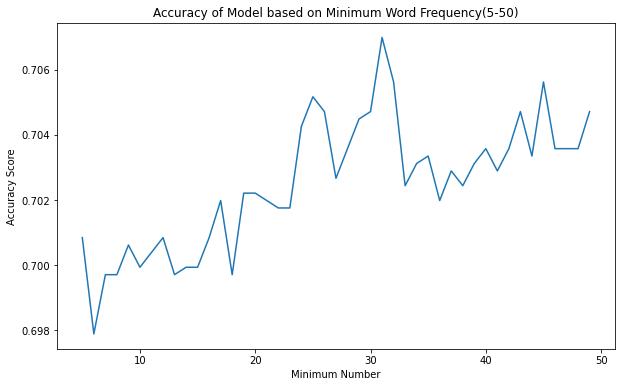

In [26]:
min_df_range = list(range(5,50))
scores_list = min_df_test(min_df_range)

x = scores_list.keys()
y = scores_list.values()

plt.figure(figsize=(10,6))
plt.plot(x,y)

plt.title('Accuracy of Model based on Minimum Word Frequency(5-50)')
plt.xlabel('Minimum Number')
plt.ylabel('Accuracy Score')

plt.show()

---

It looks like the accuracy is still increasing or perhaps not but let's try a higher range for the `min_df` parameter.

---

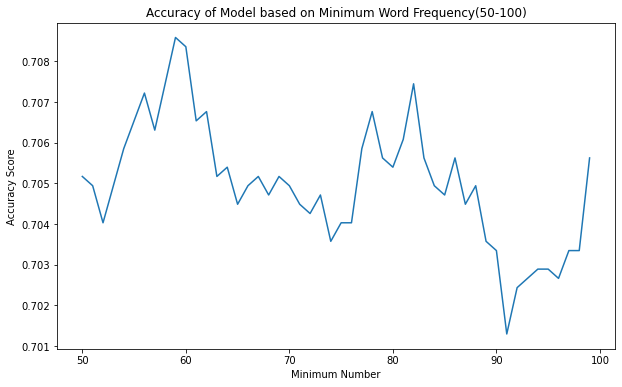

In [28]:
min_df_range_2 = list(range(50,100))
scores_list_2 = min_df_test(min_df_range_2)

x = scores_list_2.keys()
y = scores_list_2.values()

plt.figure(figsize=(10,6))
plt.plot(x,y)

plt.title('Accuracy of Model based on Minimum Word Frequency(50-100)')
plt.xlabel('Minimum Number')
plt.ylabel('Accuracy Score')

plt.show()

In [29]:
best_min_df = max(scores_list_2, key=scores_list_2.get) 

print(f'Best min_df parameter: {best_min_df}')
print(f'Accuracy with best min_df parameter: {scores_list_2[best_min_df]:.4f}')

Best min_df parameter: 59
Accuracy with best min_df parameter: 0.7086


---

Let's now test for the best `ngram_range` parameter.

---

In [30]:
def ngrams_test(number):
    scores = {}
    for n in number:
        text = yelp_data['review_stemmed']
        tf_vectorizer = TfidfVectorizer(ngram_range=(1,n), min_df=best_min_df) # input best min_df from above
        tf_vector = tf_vectorizer.fit_transform(text)
        
        vocab = tf_vectorizer.vocabulary_
        vocab_df = pd.DataFrame(tf_vector.toarray(), columns=vocab)

        col_name1 ='resturant_name'
        col_name2 = 'yelp_review'
        col_name3 = 'polarity'
        col_name4 = 'review_sentiment'
        col_name5 = 'proportion_positive'

        col1 = yelp_data['name']
        col2 = yelp_data['review']
        col3 = yelp_data['polarity']
        col4 = yelp_data['sentiment']
        col5 = yelp_data['proportion_positive']

        vocab_df.insert(0, col_name1, col1)
        vocab_df.insert(1, col_name2, col2)
        vocab_df.insert(2, col_name3, col3)
        vocab_df.insert(3, col_name4, col4)
        vocab_df.insert(4, col_name5, col5)
        
        X = vocab_df.iloc[:,4:] # features
        y = vocab_df['review_sentiment'] # target
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        
        log_reg = LogisticRegression()
        model = Pipeline([('classifier', log_reg)])
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        score = accuracy_score(predictions, y_test)
        
        scores[n] = score
        
    return scores

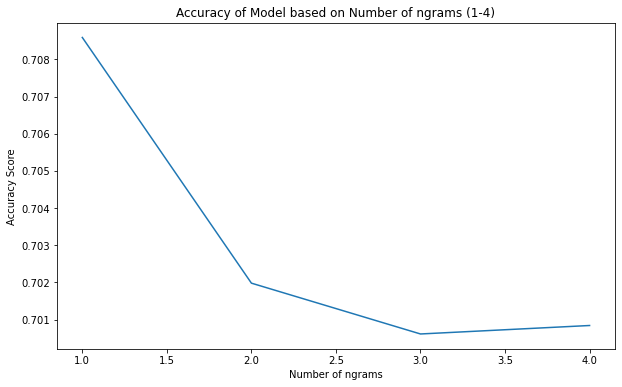

In [31]:
ngram_range = [1, 2, 3, 4]
ngram_scores_list = ngrams_test(ngram_range)

x = ngram_scores_list.keys()
y = ngram_scores_list.values()

plt.figure(figsize=(10,6))
plt.plot(x,y)

plt.title('Accuracy of Model based on Number of ngrams (1-4)')
plt.xlabel('Number of ngrams')
plt.ylabel('Accuracy Score')

plt.show()

In [32]:
best_ngram_range = max(ngram_scores_list, key=ngram_scores_list.get) 

print(f'Best ngram_range parameter: {best_ngram_range}')
print(f'Accuracy with best ngram_range parameter: {ngram_scores_list[best_ngram_range]:.4f}')

Best ngram_range parameter: 1
Accuracy with best ngram_range parameter: 0.7086


---

In this case, our ideal `ngrams_range` parameter is 1 with a `min_df` of 59! Let's create a dataframe to export for modeling.

---

In [33]:
text = yelp_data['review_stemmed']

# Input best ngram_range and min_df parameters from above
tf_vectorizer = TfidfVectorizer(ngram_range=(1,best_ngram_range), min_df=best_min_df) 
tf_vector = tf_vectorizer.fit_transform(text)

vocab = tf_vectorizer.vocabulary_
vocab_df = pd.DataFrame(tf_vector.toarray(), columns=vocab)

col_name1 ='resturant_name'
col_name2 = 'yelp_review'
col_name3 = 'polarity'
col_name4 = 'review_sentiment'
col_name5 = 'proportion_positive'

col1 = yelp_data['name']
col2 = yelp_data['review']
col3 = yelp_data['polarity']
col4 = yelp_data['sentiment']
col5 = yelp_data['proportion_positive']

vocab_df.insert(0, col_name1, col1)
vocab_df.insert(1, col_name2, col2)
vocab_df.insert(2, col_name3, col3)
vocab_df.insert(3, col_name4, col4)
vocab_df.insert(4, col_name5, col5)

In [34]:
vocab_df.head()

,resturant_name,yelp_review,polarity,review_sentiment,proportion_positive,park,bake,shop,becom,go,...,jukebox,bruschetta,calzon,pizzeria,antipasto,linguini,zucchini,player,sicilian,castl
0,Morris Park Bake Shop,morris park bake shop has become my go to spot...,0.338889,slightly positive,0.2143,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,Morris Park Bake Shop,i thought the cookies and biscotti were prett...,0.314583,slightly positive,0.1500,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,Morris Park Bake Shop,guys.... so im a big time biscotti connoisseu...,0.238068,slightly positive,0.1477,0.0,0.096569,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.152041,0.0,0.0,0.0,0.0
3,Morris Park Bake Shop,i had a craving for a special type of cake wi...,0.314643,slightly positive,0.2414,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Morris Park Bake Shop,the chocolate cups are amazing! have been eat...,0.500000,positive,0.2500,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Conclusion

As you can see, with just a simple model, we're off to a decent start at around 70% accuracy. Once we take these features and apply them to a better model and experiment with the number of ngrams etc, we should see much better performance!

In the next notebook, we're finally going to build our model which we'll need to first decide which model to use and how to improve on it.

---

In [35]:
vocab_df.to_csv('./data/yelp_data_sentiment.csv', index=False)